In [43]:
import random
import string
import re
import sys
import nltk
import spacy
import torch

import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from spacy import displacy

from nlp_project.notebook_utils import evaluate, split
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [8]:
%%capture # noqa

# Classification labels
labels = ["A", "B", "C", "D", "E", "F"]

# English stopwords
nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words("english")

# Load spacy pipeline model
!{sys.executable} -m spacy download en_core_web_sm
#import en_core_web_sm
nlp_model = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /home/riga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,It was not until many years later that it coul...,A
1,Users can then pin these images to their profi...,F
2,The best songs are those that I can sing along...,B
3,I found this book to be poorly written. It was...,D
4,Regulates the application of the EU tariff quo...,E
...,...,...
22411,The ministry had earlier said it was working w...,B
22412,"Once combined, slowly add the melted butter, s...",F
22413,Hightower for this new and wellwritten book!. ...,B
22414,All throughout the whole book this author has ...,D


In [5]:
def extract_features(tree):
    features = []
    for token in tree:
        lemma = token.lemma_
        pos_tag = token.pos_
        dep_lab = token.dep_
        head = token.head
        if token.i < head.i:
            direction = "l"
        else:
            direction = "r"
        dfr = len(list(token.ancestors))
        # if not token.is_stop:
        features.append({
            "lem": lemma ,
            "pos": pos_tag, 
            "dep": dep_lab, 
            "head": head, 
            "dir": direction, 
            "dfr": dfr
        })
    return features

In [6]:
# Run SpaCy NLP pipeline on dataset
parsed_df = df.copy()
parsed_df["text"] = df["text"].apply(lambda x: nlp_model(x))

In [7]:
# Extract useful features
parsed_df["features"] = parsed_df["text"].apply(lambda x: extract_features(x))
parsed_df

,text,label,features
0,"(It, was, not, until, many, years, later, that...",A,"[{'lem': 'it', 'pos': 'PRON', 'dep': 'nsubj', ..."
1,"(Users, can, then, pin, these, images, to, the...",F,"[{'lem': 'user', 'pos': 'NOUN', 'dep': 'nsubj'..."
2,"(The, best, songs, are, those, that, I, can, s...",B,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
3,"(I, found, this, book, to, be, poorly, written...",D,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
4,"(Regulates, the, application, of, the, EU, tar...",E,"[{'lem': 'regulate', 'pos': 'VERB', 'dep': 'RO..."
...,...,...,...
22411,"(The, ministry, had, earlier, said, it, was, w...",B,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
22412,"(Once, combined, ,, slowly, add, the, melted, ...",F,"[{'lem': 'once', 'pos': 'ADV', 'dep': 'advmod'..."
22413,"(Hightower, for, this, new, and, wellwritten, ...",B,"[{'lem': 'Hightower', 'pos': 'PROPN', 'dep': '..."
22414,"(All, throughout, the, whole, book, this, auth...",D,"[{'lem': 'all', 'pos': 'ADV', 'dep': 'advmod',..."


In [9]:
# Example structure
displacy.render(parsed_df["text"][0], jupyter=True, style='dep')

In [10]:
# Vectorize lemmas
vectorizer = CountVectorizer()
parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x = vectorizer.fit_transform(parsed_df["text_lem"])
y = parsed_df["label"]

In [11]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [22]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ["sag"], 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

In [23]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Found best model
Trained best model
Training Linear Regression
Fitting 2 folds for each of 11 candidates, totalling 22 fits


/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Found best model
Trained best model
Training SVC
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.32684586214588446
              precision    recall  f1-score   support

           A       0.37      0.47      0.42       712
           B       0.25      0.31      0.28       730
           C       0.24      0.26      0.25       737
           D       0.35      0.31      0.33       774
           E       0.34      0.27      0.30       765
           F       0.59      0.45      0.51       766

    accuracy                           0.34      4484
   macro avg       0.36      0.34      0.35      4484
weighted avg       0.36      0.34      0.35      4484



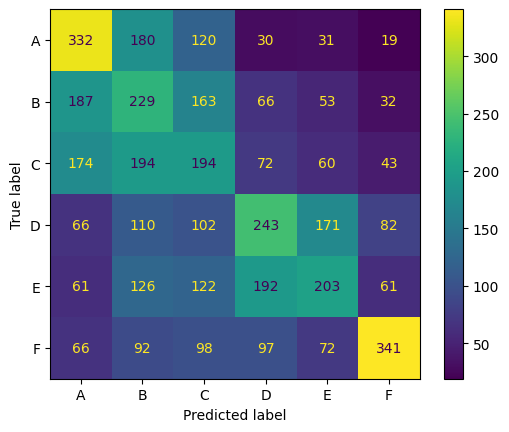

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Best CV score: 0.40893374972116886
              precision    recall  f1-score   support

           A       0.52      0.57      0.54       712
           B       0.38      0.34      0.36       730
           C       0.37      0.33      0.34       737
           D       0.38      0.37      0.37       774
           E       0.32      0.31      0.32       765
           F       0.55      0.64      0.59       766

    accuracy                           0.42      4484
   macro avg       0.42      0.43      0.42      4484
weighted avg       0.42      0.42      0.42      4484



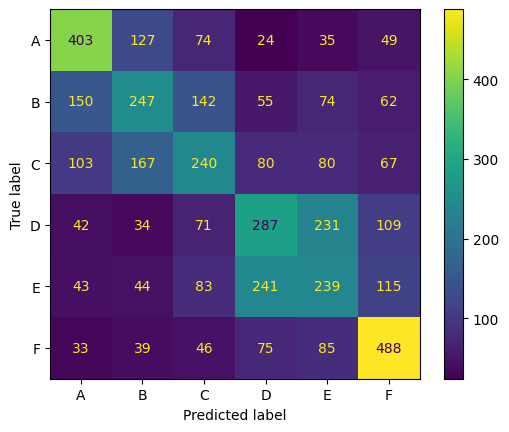

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.3915226013733495
              precision    recall  f1-score   support

           A       0.55      0.59      0.57       712
           B       0.37      0.37      0.37       730
           C       0.38      0.38      0.38       737
           D       0.40      0.42      0.41       774
           E       0.37      0.34      0.35       765
           F       0.66      0.66      0.66       766

    accuracy                           0.46      4484
   macro avg       0.46      0.46      0.46      4484
weighted avg       0.46      0.46      0.46      4484



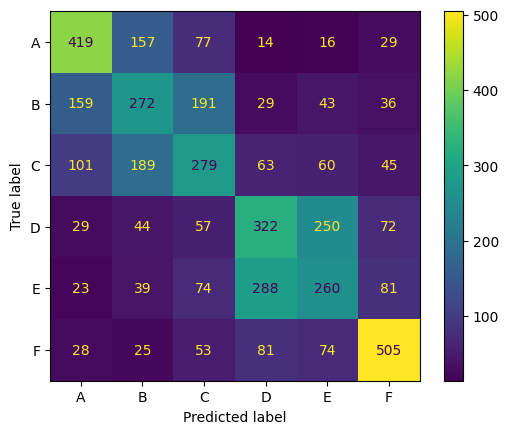

In [24]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [25]:
# Vectorize lemmas
vectorizer = CountVectorizer()
parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x_lem = vectorizer.fit_transform(parsed_df["text_lem"])

# Vectorize POS tags
vectorizer = CountVectorizer()
parsed_df["text_pos"] = parsed_df["features"].apply(lambda x: " ".join([t["pos"] for t in x]))
x_pos = vectorizer.fit_transform(parsed_df["text_pos"])

In [26]:
# Concatenate vectors
x = sps.hstack([x_lem, x_pos])
y = parsed_df["label"]

In [27]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [28]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dt, dt_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Decision Tree", "model": dtree_clf})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Random Forest", "model": rf_clf})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=2, scoring="f1_micro", verbose=1)
models.append({"name": "Extra Trees", "model": et_clf})

In [29]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Found best model
Trained best model
Training Linear Regression
Fitting 2 folds for each of 17 candidates, totalling 34 fits


/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riga/.cache/pypoetry/virtualenvs/nlp-project-McHdYL_A-py3.11/lib/pytho

Found best model
Trained best model
Training SVC
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Found best model
Trained best model
Training Decision Tree
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Found best model
Trained best model
Training Random Forest
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Found best model
Trained best model
Training Extra Trees
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.3198193174213696
              precision    recall  f1-score   support

           A       0.44      0.48      0.46       712
           B       0.24      0.35      0.28       730
           C       0.24      0.23      0.24       737
           D       0.32      0.29      0.30       774
           E       0.29      0.24      0.26       765
           F       0.58      0.44      0.50       766

    accuracy                           0.34      4484
   macro avg       0.35      0.34      0.34      4484
weighted avg       0.35      0.34      0.34      4484



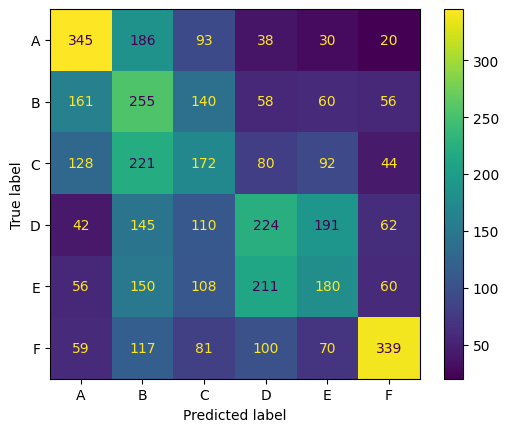

Linear Regression
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.4193620343519965
              precision    recall  f1-score   support

           A       0.52      0.61      0.56       712
           B       0.39      0.30      0.34       730
           C       0.41      0.30      0.35       737
           D       0.38      0.36      0.37       774
           E       0.34      0.29      0.31       765
           F       0.47      0.72      0.57       766

    accuracy                           0.43      4484
   macro avg       0.42      0.43      0.42      4484
weighted avg       0.42      0.43      0.42      4484



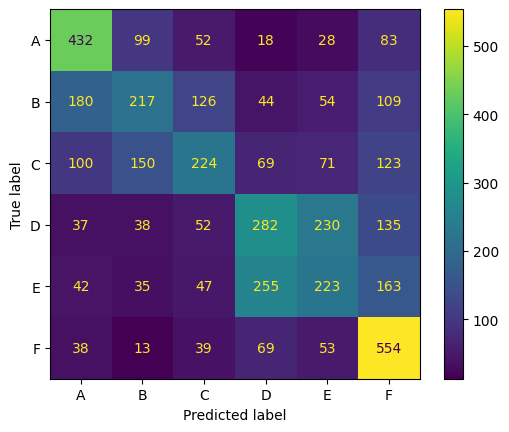

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.4231265751561159
              precision    recall  f1-score   support

           A       0.59      0.61      0.60       712
           B       0.41      0.39      0.40       730
           C       0.40      0.39      0.40       737
           D       0.44      0.39      0.42       774
           E       0.40      0.36      0.37       765
           F       0.57      0.72      0.64       766

    accuracy                           0.48      4484
   macro avg       0.47      0.48      0.47      4484
weighted avg       0.47      0.48      0.47      4484



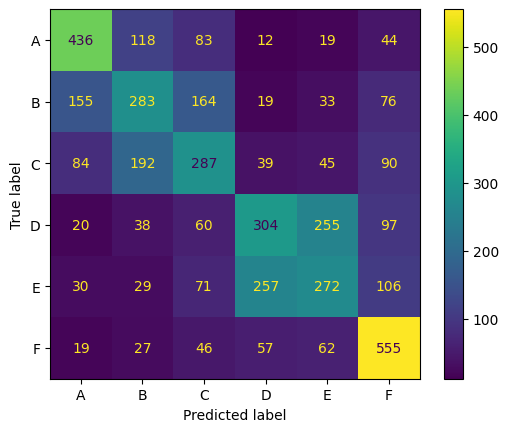

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.29310729422261883
              precision    recall  f1-score   support

           A       0.38      0.38      0.38       712
           B       0.26      0.26      0.26       730
           C       0.20      0.18      0.19       737
           D       0.29      0.27      0.28       774
           E       0.23      0.23      0.23       765
           F       0.42      0.45      0.43       766

    accuracy                           0.30      4484
   macro avg       0.29      0.30      0.30      4484
weighted avg       0.29      0.30      0.30      4484



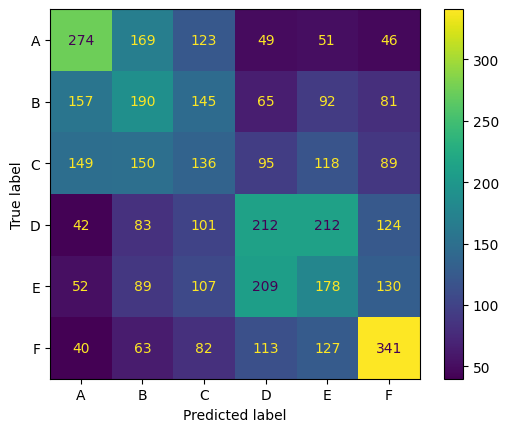

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.40642426946241356
              precision    recall  f1-score   support

           A       0.48      0.57      0.52       712
           B       0.35      0.26      0.30       730
           C       0.31      0.16      0.22       737
           D       0.37      0.46      0.41       774
           E       0.34      0.29      0.31       765
           F       0.49      0.71      0.58       766

    accuracy                           0.41      4484
   macro avg       0.39      0.41      0.39      4484
weighted avg       0.39      0.41      0.39      4484



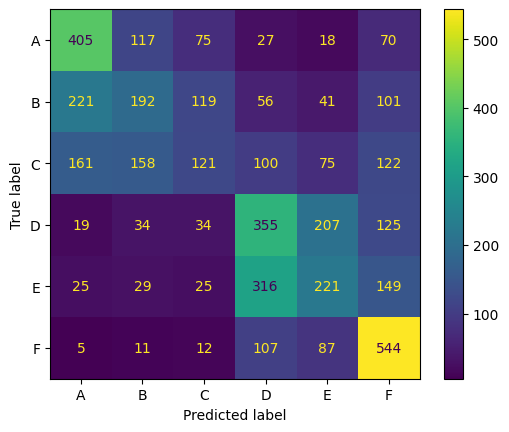

Extra Trees
Best parameters: {'criterion': 'gini'}
Best CV score: 0.4080414900736114
              precision    recall  f1-score   support

           A       0.50      0.53      0.51       712
           B       0.32      0.27      0.29       730
           C       0.35      0.20      0.26       737
           D       0.39      0.51      0.44       774
           E       0.34      0.28      0.31       765
           F       0.50      0.70      0.58       766

    accuracy                           0.42      4484
   macro avg       0.40      0.42      0.40      4484
weighted avg       0.40      0.42      0.40      4484



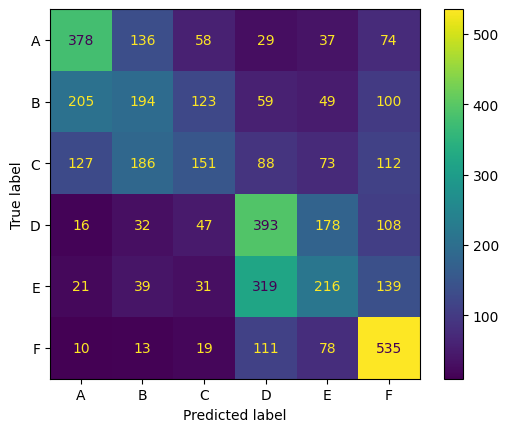

In [30]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [32]:
in_dim = x.shape[1]
out_dim = 1 if len(labels) <= 2 else len(labels)

epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [51]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.5)
        
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sm(self.l3(x))
        return x

In [55]:
y_ = LabelEncoder().fit_transform(y).astype(float)
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y_, test_size=0.1, val_size=0.1)
ds_train = Data(x_train, y_train, y_type=torch.long)
ds_val = Data(x_val, y_val, y_type=torch.long)
ds_test = Data(x_test, y_test, y_type=torch.long)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [56]:
nn_model = Network(in_dim, out_dim, binary_classifier=False, device=device)
loss = nn.CrossEntropyLoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.001)
nn_model.compile(loss, optimizer)

In [57]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.3)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0549565 acc: 0.3017510 val_loss: 0.0552396 val_acc: 0.3206958
Epoch 2 -- loss: 0.0542378 acc: 0.3471448 val_loss: 0.0551998 val_acc: 0.3211418
Epoch 3 -- loss: 0.0537515 acc: 0.3941557 val_loss: 0.0550078 val_acc: 0.3483497
Epoch 4 -- loss: 0.0532896 acc: 0.4378206 val_loss: 0.0549835 val_acc: 0.3563782
Epoch 5 -- loss: 0.0528670 acc: 0.4658153 val_loss: 0.0550766 val_acc: 0.3416592
Epoch 6 -- loss: 0.0526700 acc: 0.4830471 val_loss: 0.0549440 val_acc: 0.3595004
Epoch 7 -- loss: 0.0524775 acc: 0.5008923 val_loss: 0.0548718 val_acc: 0.3675290
Epoch 8 -- loss: 0.0522993 acc: 0.5206892 val_loss: 0.0550572 val_acc: 0.3786798
Epoch 9 -- loss: 0.0522148 acc: 0.5267120 val_loss: 0.0549998 val_acc: 0.3684210
Epoch 10 -- loss: 0.0522175 acc: 0.5360250 val_loss: 0.0549446 val_acc: 0.3693131
Epoch 11 -- loss: 0.0521317 acc: 0.5407651 val_loss: 0.0552103 val_acc: 0.3728814
Epoch 12 -- loss: 0.0521345 acc: 0.5560451 val_loss: 0.0551666 val_acc: 0.3630687
Reducing lr to 0.0001
Epo

{'acc': tensor(0.3956), 'loss': 0.055004903028098524}
              precision    recall  f1-score   support

         0.0       0.53      0.39      0.45       356
         1.0       0.34      0.41      0.37       365
         2.0       0.29      0.36      0.32       368
         3.0       0.39      0.33      0.36       387
         4.0       0.34      0.34      0.34       383
         5.0       0.58      0.54      0.56       383

    accuracy                           0.40      2242
   macro avg       0.41      0.40      0.40      2242
weighted avg       0.41      0.40      0.40      2242



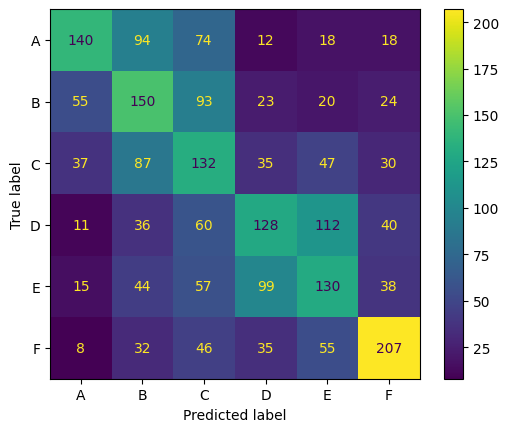

In [58]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

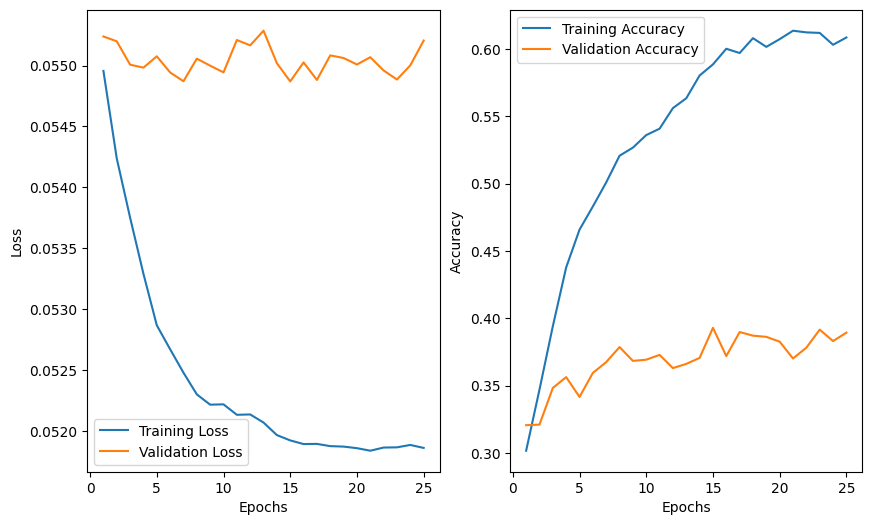

In [59]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()